In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    f1_score,
    make_scorer,
)
from sklearn.tree import DecisionTreeRegressor, plot_tree, DecisionTreeClassifier
from category_encoders import LeaveOneOutEncoder

from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

import matplotlib.pyplot as plt

%matplotlib inline

# https://www.kaggle.com/ronitf/heart-disease-uci?select=heart.csv

<IPython.core.display.Javascript object>

In [3]:
def eval_preds(y_true, y_pred):
    """Display some metrics for evaluating regression predictions"""
    error = y_true - y_pred

    rmse = np.mean(np.sqrt((error ** 2)))
    mae = np.mean(np.abs(error))
    mape = np.mean(np.abs((error / y_true)))

    print(f"rmse {rmse:.2f}")
    print(f"mae {mae:.2f}")
    print(f"mape {mape:.2f}")

    line_pts = [np.min(y_true), np.max(y_true)]
    plt.scatter(y_true, y_pred)
    plt.plot(line_pts, line_pts, c="red", ls="--", alpha=0.5)
    plt.xlabel("Actual")
    plt.ylabel("Fit")
    plt.show()

<IPython.core.display.Javascript object>

In [4]:
heart_df = pd.read_csv("data/heart.csv")

<IPython.core.display.Javascript object>

In [5]:
heart_df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


<IPython.core.display.Javascript object>

In [6]:
heart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


<IPython.core.display.Javascript object>

In [7]:
heart_df.corr()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
age,1.000000,-0.098447,-0.068653,0.279351,0.213678,0.121308,-0.116211,-0.398522,0.096801,0.210013,-0.168814,0.276326,0.068001,-0.225439
sex,-0.098447,1.000000,-0.049353,-0.056769,-0.197912,0.045032,-0.058196,-0.044020,0.141664,0.096093,-0.030711,0.118261,0.210041,-0.280937
cp,-0.068653,-0.049353,1.000000,0.047608,-0.076904,0.094444,0.044421,0.295762,-0.394280,-0.149230,0.119717,-0.181053,-0.161736,0.433798
trestbps,0.279351,-0.056769,0.047608,1.000000,0.123174,0.177531,-0.114103,-0.046698,0.067616,0.193216,-0.121475,0.101389,0.062210,-0.144931
chol,0.213678,-0.197912,-0.076904,0.123174,1.000000,0.013294,-0.151040,-0.009940,0.067023,0.053952,-0.004038,0.070511,0.098803,-0.085239
fbs,0.121308,0.045032,0.094444,0.177531,0.013294,1.000000,-0.084189,-0.008567,0.025665,0.005747,-0.059894,0.137979,-0.032019,-0.028046
restecg,-0.116211,-0.058196,0.044421,-0.114103,-0.151040,-0.084189,1.000000,0.044123,-0.070733,-0.058770,0.093045,-0.072042,-0.011981,0.137230
thalach,-0.398522,-0.044020,0.295762,-0.046698,-0.009940,-0.008567,0.044123,1.000000,-0.378812,-0.344187,0.386784,-0.213177,-0.096439,0.421741
exang,0.096801,0.141664,-0.394280,0.067616,0.067023,0.025665,-0.070733,-0.378812,1.000000,0.288223,-0.257748,0.115739,0.206754,-0.436757
oldpeak,0.210013,0.096093,-0.149230,0.193216,0.053952,0.005747,-0.058770,-0.344187,0.288223,1.000000,-0.577537,0.222682,0.210244,-0.430696


<IPython.core.display.Javascript object>

In [8]:
# possible colinearity between thalach and [exang, oldpeak, ca]
cols_of_interest = [
    "cp",
    "thalach",
    "exang",
    "oldpeak",
    "slope",
    "ca",
    "thal",
    "age",
    "sex",
]

<IPython.core.display.Javascript object>

In [42]:
heart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


<IPython.core.display.Javascript object>

In [117]:
cat_cols = [
    'sex',
    'cp',
    'fbs', # true/false
    'restecg', # looks like 0,1,2; units unclear
    'exang', # yes/no
    
]

# `oldpeak`: continuous, but small range. may want to scale

X = heart_df.drop(columns="target")
y = heart_df["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

encoder = LeaveOneOutEncoder(cols=cat_cols)

encoder.fit(X_train, y_train)

X_train = encoder.transform(X_train)
X_test = encoder.transform(X_test)


<IPython.core.display.Javascript object>

In [55]:
X.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2


<IPython.core.display.Javascript object>

In [58]:
X["fbs"].value_counts()

0    258
1     45
Name: fbs, dtype: int64

<IPython.core.display.Javascript object>

In [59]:
X_test["fbs"].value_counts()

0.571429    55
0.512821     6
Name: fbs, dtype: int64

<IPython.core.display.Javascript object>

In [118]:
grid = [{"max_depth": [3, 4, 5, 6],}]

tree1 = GridSearchCV(DecisionTreeClassifier(), param_grid=grid, cv=10)
tree1.fit(X_train, y_train)

print(tree1.score(X_train, y_train))
print(tree1.score(X_test, y_test))
# dir(tree1)

# pretty consistent .85 to 0.789 split, sometimes over fits

0.8966942148760331
0.7704918032786885


<IPython.core.display.Javascript object>

In [246]:
# rerun tree with kbest columns
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

encoder = LeaveOneOutEncoder(cols=cat_cols)

encoder.fit(X_train, y_train)

X_train = encoder.transform(X_train)
X_test = encoder.transform(X_test)

# ten is the sweet spot, maybe???
selector = SelectKBest(k=10)
selector.fit(X_train, y_train)

col_names = X_train.columns

X_train = selector.transform(X_train)
X_test = selector.transform(X_test)

grid = [{"max_depth": [30, 50, 100]}]

tree2 = GridSearchCV(DecisionTreeClassifier(), param_grid=grid, cv=10)
tree2.fit(X_train, y_train)

print(tree2.score(X_train, y_train))
print(tree2.score(X_test, y_test))

# overfitting, consistent 0.78 - 0.95 split. max depth best around 6-7
# k = 13, max depth is 30

1.0
0.7868852459016393


<IPython.core.display.Javascript object>

In [262]:
y_pred = tree2.predict(X_test)
y_prob = tree2.predict_proba(X_test)

<IPython.core.display.Javascript object>

In [263]:
print(tree2.best_params_)
print(confusion_matrix(y_test, y_pred))

{'max_depth': 30}
[[18  7]
 [ 6 30]]


<IPython.core.display.Javascript object>

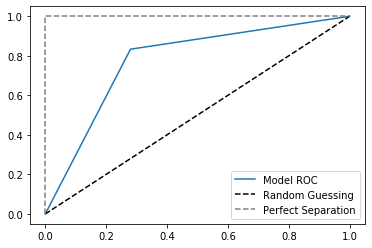

<IPython.core.display.Javascript object>

In [264]:
y_pred = tree2.predict(X_test)
y_prob = tree2.predict_proba(X_test)

fpr, tpr, _ = roc_curve(y_test, y_prob[:, 1])
roc_auc_score(y_test, y_prob[:, 1])

plt.plot(fpr, tpr, label="Model ROC")
plt.plot([0, 1], [0, 1], "--", c="black", label="Random Guessing")
plt.plot([0, 0, 1], [0, 1, 1], "--", c="gray", label="Perfect Separation")
plt.legend()
plt.show()

In [265]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.72      0.73        25
           1       0.81      0.83      0.82        36

    accuracy                           0.79        61
   macro avg       0.78      0.78      0.78        61
weighted avg       0.79      0.79      0.79        61



<IPython.core.display.Javascript object>

In [250]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
grid = [{"max_depth": [6, 7, 9], "n_estimators": [100, 250, 500, 1000]}]

forest1 = GridSearchCV(RandomForestClassifier(), param_grid=grid, cv=10)

forest1.fit(X_train, y_train)

print(forest1.best_params_)
print(forest1.score(X_train, y_train))
print(forest1.score(X_test, y_test))

{'max_depth': 9, 'n_estimators': 100}
1.0
0.8688524590163934


<IPython.core.display.Javascript object>

In [256]:
y_pred = forest1.predict(X_test)
y_prob = forest1.predict_proba(X_test)

<IPython.core.display.Javascript object>

In [257]:
print(forest1.best_params_)
print(confusion_matrix(y_test, y_pred))

{'max_depth': 9, 'n_estimators': 100}
[[20  5]
 [ 3 33]]


<IPython.core.display.Javascript object>

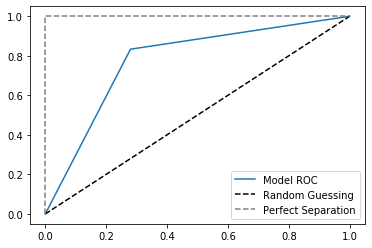

<IPython.core.display.Javascript object>

In [258]:
y_pred = tree2.predict(X_test)
y_prob = tree2.predict_proba(X_test)

fpr, tpr, _ = roc_curve(y_test, y_prob[:, 1])
roc_auc_score(y_test, y_prob[:, 1])

plt.plot(fpr, tpr, label="Model ROC")
plt.plot([0, 1], [0, 1], "--", c="black", label="Random Guessing")
plt.plot([0, 0, 1], [0, 1, 1], "--", c="gray", label="Perfect Separation")
plt.legend()
plt.show()

In [261]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.72      0.73        25
           1       0.81      0.83      0.82        36

    accuracy                           0.79        61
   macro avg       0.78      0.78      0.78        61
weighted avg       0.79      0.79      0.79        61



<IPython.core.display.Javascript object>

In [259]:
importances = pd.DataFrame(
    {
        "feature": X[col_names].columns,
        "importance": forest1.best_estimator_.feature_importances_,
    }
).sort_values(by="importance", ascending=False)

importances

ValueError: arrays must all be same length

<IPython.core.display.Javascript object>

In [16]:
# select features with >= 0.1

important_features = importances.loc[
    importances["importance"] >= 0.1, "feature"
].tolist()

<IPython.core.display.Javascript object>

In [34]:
cols_of_interest = important_features

X = heart_df[cols_of_interest].copy()
y = heart_df["target"].copy()

<IPython.core.display.Javascript object>

In [36]:
# X = heart_df[cols_of_interest]


pandas.core.series.Series

<IPython.core.display.Javascript object>

This exersize would have been better served with a larger data set. The models tended to over fit, and there is some ambiguity as to which KBest value is best. High precision and recall, with room to tuib